# Load files and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

In [3]:
valence = pd.read_csv('/content/drive/MyDrive/deam/valence.csv').T
arousal = pd.read_csv('/content/drive/MyDrive/deam/arousal.csv').T

In [ ]:
valence

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801
song_id,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,13.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,24.000000,25.000000,31.000000,32.000000,35.000000,37.000000,39.000000,40.000000,41.000000,42.000000,43.000000,44.000000,45.000000,46.000000,47.000000,48.000000,49.000000,50.000000,51.000000,52.000000,53.000000,54.000000,55.000000,56.000000,58.000000,...,2019.000,2020.000,2021.000,2022.000,2023.000,2024.000,2025.000,2026.000,2027.000,2028.000,2029.000000,2030.000,2031.000,2032.000,2033.000000,2034.000,2035.000,2036.000000,2037.000,2038.000,2039.000,2040.000,2041.000,2042.000,2043.000,2044.000,2045.000,2046.00,2047.000,2048.000,2049.000,2050.000,2051.000,2052.000,2053.000,2054.000,2055.000,2056.000,2057.000000,2058.000
sample_15000ms,-0.073341,-0.189702,0.154286,0.149053,0.342816,0.060866,0.091968,0.330863,-0.183663,0.150160,0.082292,0.079942,0.318925,0.328149,0.021629,0.000853,-0.270613,-0.163408,-0.138077,0.332432,0.149901,0.165300,-0.018559,-0.064770,0.049989,-0.081521,-0.138695,-0.462991,-0.226122,0.026502,0.188798,0.193418,-0.013442,-0.089933,0.158911,-0.065908,-0.173073,0.102454,0.131472,-0.058978,...,0.338,0.214,0.040,-0.200,0.136,0.178,0.210,0.072,0.224,-0.058,0.025000,0.054,0.020,0.234,-0.161667,0.254,-0.140,-0.153333,0.130,-0.050,0.080,-0.028,-0.060,-0.082,0.180,0.254,-0.052,0.27,0.166,-0.036,0.006,-0.004,-0.226,-0.208,-0.114,0.088,0.128,0.198,-0.071667,-0.152
sample_15500ms,-0.074661,-0.187765,0.148063,0.148260,0.345193,0.062006,0.095412,0.328418,-0.183469,0.146421,0.076663,0.080880,0.320826,0.328520,0.023658,0.002377,-0.285563,-0.163408,-0.137785,0.330943,0.158772,0.159530,-0.015613,-0.063041,0.050817,-0.082391,-0.143632,-0.461147,-0.222884,0.025533,0.239677,0.185451,-0.014783,-0.092668,0.151170,-0.054197,-0.168227,0.100342,0.115053,-0.045329,...,0.344,0.206,0.032,-0.206,0.132,0.178,0.210,0.072,0.232,-0.062,0.018333,0.058,0.022,0.226,-0.163333,0.252,-0.142,-0.153333,0.140,-0.068,0.082,-0.026,-0.058,-0.078,0.196,0.228,-0.038,0.27,0.174,-0.042,0.006,0.000,-0.226,-0.210,-0.114,0.088,0.098,0.182,-0.061667,-0.154
sample_16000ms,-0.074077,-0.183740,0.146956,0.147369,0.332023,0.062861,0.095003,0.327078,-0.189290,0.145061,0.069885,0.081294,0.324251,0.328506,0.022835,0.000786,-0.293624,-0.163408,-0.136568,0.332322,0.232510,0.157972,-0.012173,-0.056573,0.047023,-0.083517,-0.155679,-0.458141,-0.218429,0.025435,0.143471,0.183282,-0.012987,-0.122156,0.144913,-0.062162,-0.172225,0.100342,0.112926,-0.039452,...,0.348,0.174,0.028,-0.224,0.132,0.178,0.218,0.072,0.244,-0.066,0.015000,0.066,0.020,0.226,-0.168333,0.252,-0.142,-0.153333,0.138,-0.086,0.082,-0.028,-0.058,-0.072,0.190,0.216,-0.024,0.27,0.196,-0.042,0.006,0.018,-0.226,-0.212,-0.114,0.086,0.080,0.164,-0.076667,-0.160
sample_16500ms,-0.078154,-0.188761,0.151180,0.146956,0.328887,0.053099,0.096409,0.329520,-0.188153,0.144564,0.068196,0.075143,0.324976,0.328150,0.020271,0.000671,-0.302610,-0.163408,-0.135538,0.335236,0.260473,0.154003,-0.013460,-0.040612,0.046588,-0.084565,-0.155738,-0.458932,-0.218344,0.025435,0.125218,0.177557,-0.006957,-0.090630,0.136058,-0.056286,-0.172475,0.100088,0.113245,-0.051045,...,0.346,0.210,0.026,-0.234,0.128,0.178,0.224,0.122,0.278,-0.070,0.016667,0.062,0.018,0.224,-0.161667,0.254,-0.142,-0.153333,0.154,-0.090,0.084,-0.028,-0.060,-0.074,0.196,0.232,-0.004,0.27,0.204,-0.050,0.006,0.032,-0.226,-0.212,-0.114,0.080,0.080,0.156,-0.078333,-0.162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
arousal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801
song_id,2.000000,3.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,13.000000,17.000000,18.000000,19.000000,20.000000,21.000000,22.000000,24.000000,25.000000,31.000000,32.000000,35.000000,37.000000,39.000000,40.000000,41.000000,42.000000,43.000000,44.000000,45.000000,46.000000,47.000000,48.000000,49.000000,50.000000,51.000000,52.000000,53.000000,54.000000,55.000000,56.000000,58.000000,...,2019.000,2020.000,2021.000,2022.000,2023.000,2024.000,2025.000,2026.000,2027.000,2028.000,2029.000000,2.030000e+03,2031.000,2032.000,2033.000000,2034.000,2035.000,2036.000000,2037.000,2038.000,2039.000,2040.000,2041.000,2042.000,2043.000,2044.000,2045.000,2046.000,2047.000,2048.000,2049.000,2050.000,2051.000,2052.000,2053.000,2054.000,2055.000,2056.000,2057.000000,2.058000e+03
sample_15000ms,-0.109386,-0.110846,0.222327,-0.255613,0.464234,-0.138132,-0.129007,0.222143,-0.342129,0.015965,-0.166028,0.329243,0.033305,0.392352,-0.161469,0.078244,0.502565,0.060781,-0.002538,0.033664,0.355318,0.555264,-0.308848,-0.138384,0.289948,0.375329,-0.248746,0.046960,0.247087,0.032962,0.030069,-0.047292,-0.341319,-0.306913,0.014349,-0.065219,-0.146258,0.225449,0.280732,-0.288553,...,0.390,0.126,-0.028,-0.158,-0.262,-0.148,-0.172,-0.298,0.216,0.092,-0.008333,-1.110223e-17,-0.190,-0.018,-0.068333,-0.048,-0.376,-0.110000,-0.162,-0.226,-0.222,0.230,-0.398,-0.428,-0.082,-0.228,-0.484,0.092,0.054,-0.262,-0.282,-0.300,-0.166,-0.082,-0.390,-0.190,-0.070,-0.044,0.413333,8.000000e-03
sample_15500ms,-0.114942,-0.123973,0.179446,-0.251579,0.460789,-0.136934,-0.132931,0.224873,-0.346549,0.017168,-0.166028,0.325206,0.039144,0.390813,-0.163651,0.087365,0.511875,0.050972,0.001602,0.027454,0.354237,0.559063,-0.310728,-0.140185,0.290908,0.376014,-0.253838,0.045797,0.247174,0.033603,0.030506,-0.045115,-0.341750,-0.316228,0.017447,-0.065219,-0.145852,0.225834,0.300117,-0.287658,...,0.394,0.110,-0.030,-0.164,-0.224,-0.148,-0.170,-0.296,0.246,0.096,-0.008333,4.000000e-03,-0.188,-0.018,-0.070000,-0.046,-0.372,-0.108333,-0.160,-0.222,-0.226,0.236,-0.400,-0.368,-0.092,-0.260,-0.472,0.106,0.058,-0.272,-0.282,-0.306,-0.164,-0.064,-0.382,-0.182,-0.086,-0.044,0.413333,2.000000e-03
sample_16000ms,-0.116413,-0.131103,0.178388,-0.251958,0.460991,-0.140469,-0.138653,0.230734,-0.347545,0.017347,-0.166052,0.321572,0.039702,0.382354,-0.163199,0.090140,0.509121,0.046551,0.001554,0.018302,0.350253,0.563615,-0.314575,-0.139320,0.295897,0.384031,-0.257063,0.048372,0.249163,0.028692,0.034819,-0.023883,-0.343048,-0.319494,0.020951,-0.065219,-0.146585,0.221756,0.302063,-0.298348,...,0.398,0.106,-0.066,-0.148,-0.226,-0.148,-0.166,-0.296,0.288,0.092,-0.006667,-2.000000e-03,-0.178,-0.018,-0.068333,-0.036,-0.360,-0.108333,-0.156,-0.228,-0.216,0.240,-0.406,-0.304,-0.086,-0.260,-0.472,0.116,0.056,-0.296,-0.282,-0.312,-0.166,-0.058,-0.370,-0.180,-0.110,-0.044,0.411667,-2.775558e-18
sample_16500ms,-0.118613,-0.135956,0.184056,-0.251124,0.461046,-0.138988,-0.139502,0.231653,-0.349167,0.017458,-0.166487,0.305424,0.042467,0.381724,-0.152917,0.091470,0.536576,0.041884,-0.000563,0.016891,0.346854,0.567587,-0.314526,-0.138844,0.302138,0.392704,-0.258602,0.047013,0.248955,0.027743,0.033393,-0.031593,-0.318811,-0.322047,0.021866,-0.065219,-0.147779,0.217858,0.293552,-0.302611,...,0.398,0.072,-0.088,-0.112,-0.216,-0.148,-0.204,-0.302,0.296,0.082,-0.006667,1.800000e-02,-0.176,-0.018,-0.068333,-0.034,-0.312,-0.113333,-0.174,-0.216,-0.222,0.240,-0.408,-0.276,-0.088,-0.166,-0.466,0.130,0.070,-0.306,-0.278,-0.308,-0.166,-0.072,-0.368,-0.158,-0.072,-0.044,0.410000,6.000000e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Get labels (IGNORE THIS)


## Get labels for each sample in the song
Each song has samples of 0.5s length. This code takes 60 sequential samples and finds their labels based on their valence and arousal.

In [ ]:
def get_all_labels_for_each_sample_in_song(valence, arousal):
  all_labels = {}
  for i in range(len(valence.columns)):
    labels = []
    for num in range(15000, 626001, 500):
      v = valence[i]['sample_'+str(num)+'ms']
      a = arousal[i]['sample_'+str(num)+'ms']
      labels.append(categorise(v,a,0.2))

    #cutting or padding if len(labels) != 60
    if len(labels) > 60:
       labels = labels[:60]
    elif len(labels) < 60:
      most_common_no = max(set(labels), key = labels.count)
      labels += [most_common_no]*(60-len(labels))
    
    all_labels[int(valence[i]['song_id'])] = keras.utils.to_categorical(labels, num_classes=5)

  return all_labels

## Get labels for each song
Each song has samples of 0.5s length. This code takes 60 sequential samples and finds their labels based on their valence and arousal. It then takes the category with the highest count to use as the label of the song.

In [ ]:
def get_all_labels_for_each_song(valence, arousal):
  all_labels = {}
  for i in range(len(valence.columns)):
    labels = []
    for num in range(15000, 626001, 500):
      v = valence[i]['sample_'+str(num)+'ms']
      a = arousal[i]['sample_'+str(num)+'ms']
      labels.append(categorise(v,a,0.2))

    most_common_no = max(set(labels), key = labels.count)
    all_labels[int(valence[i]['song_id'])] = keras.utils.to_categorical(most_common_no, num_classes=5)

  return all_labels

# Get Feature Data (IGNORE THIS)

In [4]:
def get_all_data():
  all_data = {}
  dir = '/content/drive/MyDrive/deam/features/'
  for filename in tqdm(os.listdir(dir)):
    try:
      f = open(dir+filename, 'r')
      reader = list(csv.reader(f, delimiter=';'))
      if len(reader) < 91:
        pad = [reader[len(reader)-1]]*(91-len(reader))
        all_data[int(filename.strip('.csv'))] = reader[31:]+pad
      else:
        all_data[int(filename.strip('.csv'))] = reader[31:91]
    except:
      print("An exception occurred")
  
  return all_data

In [5]:
all_data = get_all_data()

100%|██████████| 1802/1802 [17:35<00:00,  1.71it/s]


# Get Labels and Feature Data

In [6]:
def categorise(v, a, bound):
  if v > bound and a > bound:
    return 0
  elif v > bound and a < bound:
    return 1
  elif v < bound and a > bound:
    return 2
  elif v < bound and a < bound:
    return 3
  else:
    return 4

In [7]:
def get_data_and_labels_for_each_sample_in_song(valence, arousal):
  all_labels = {}
  all_data = {}
  dir = '/content/drive/MyDrive/deam/features/'

  for i in range(len(valence.columns)):
    labels = []
    data = []

    filename = str(int(valence[i]['song_id']))+'.csv'
    f = open(dir+filename, 'r')
    reader = list(csv.reader(f, delimiter=';'))

    if len(reader) < 91:
      pad = [reader[len(reader)-1]]*(91-len(reader))
      reader = reader+pad
    
    for num in range(15000, 45001, 500):
      v = valence[i]['sample_'+str(num)+'ms']
      a = arousal[i]['sample_'+str(num)+'ms']

      category = categorise(v,a,0.1)
      # removes sample of category 4 from reader
      if category != 4:
        labels.append(category)
        data.append(reader[num//500])

    #cutting or padding if len(labels) != 60
    if len(labels) > 60:
       labels = labels[:60]
       data = data[:60]
    elif len(labels) < 60:
      #most_common_no = max(set(labels), key = labels.count)
      labels += [labels[-1]]*(60-len(labels))
      data += [data[-1]]*(60-len(data))

    if len(labels) != len(data):
      print(len(labels), len(data))
    
    all_labels[int(valence[i]['song_id'])] = keras.utils.to_categorical(labels, num_classes=4)
    all_data[int(valence[i]['song_id'])] = data

  return all_labels, all_data

# Build X and y

In [8]:
def build_X_y(all_data, all_labels):
  X = []
  y = []
  for key in all_data.keys():
    X.append(all_data[key])
    y.append(all_labels[key])

  X = np.array(X, dtype=np.float32, ndmin=3)
  y = np.array(y, dtype=np.int32)

  print('X.shape:', X.shape) 
  print('y.shape:', y.shape)

  return X, y

# Build model

## Build model for predicting the label of each sample in the song (USE THIS ONE)

In [9]:
def build_model_for_each_sample_in_song_prediction(input_shape):
  model = keras.Sequential()
  model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
  # model.add(keras.layers.LSTM(64))
  # model.add(keras.layers.RepeatVector(60))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(4, activation='softmax'))

  return model

## Build model for predicting the label of each song

In [ ]:
def build_model_for_each_song_prediction(input_shape):
  model = keras.Sequential()
  model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
  model.add(keras.layers.LSTM(64))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(5, activation='softmax'))

  return model

# Evaluate model

In [10]:
def confusion(y_pred, y_test):
  y_pred_reshape = np.argmax(y_pred, axis=2)
  y_pred_reshape = y_pred_reshape.flatten()

  y_test_reshape = np.argmax(y_test, axis=2)
  y_test_reshape = y_test_reshape.flatten()

  cm = confusion_matrix(y_test_reshape, y_pred_reshape)
  ConfusionMatrixDisplay(cm).plot()

In [11]:
def optimise_fit_eval(model, X_train, X_test, y_train, y_test):
  optimiser = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  model.fit(X_train, y_train, batch_size=32, epochs=30)
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print('\nTest accuracy:', test_acc)

  confusion(model.predict(X_test), y_test)
  

# Main 

In [12]:
def TESTING(valence, arousal, all_labels, all_data):
  X, y = build_X_y(all_data, all_labels)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = build_model_for_each_sample_in_song_prediction((X_train.shape[1], X_train.shape[2]))

  optimise_fit_eval(model, X_train, X_test, y_train, y_test)

In [13]:
all_labels, all_data = get_data_and_labels_for_each_sample_in_song(valence, arousal)

X.shape: (1802, 60, 261)
y.shape: (1802, 60, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            83456     
                                                                 
 dense (Dense)               (None, 60, 64)            4160      
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 60, 4)             260       
                                                                 
Total params: 87,876
Trainable params: 87,876
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
46/46 [==============================] - 6s 17ms/step - loss: 1.4791 - accuracy: 0.2570
Epoch 2/30
46/46 [===================

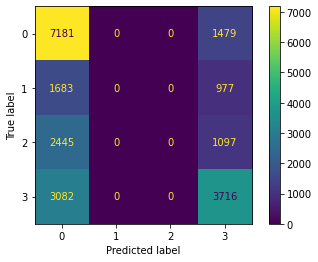

In [14]:
TESTING(valence, arousal, all_labels, all_data)

# Others

In [ ]:
def TESTING_STRATIFIED(valence, arousal, all_labels, all_data):
  X, y = build_X_y(all_data, all_labels)

  temp_y = []
  for i in range(1802):
    not_one_hot = y[i].argmax(axis=1).tolist()
    most_common_no = max(set(not_one_hot), key = not_one_hot.count)
    temp_y.append(most_common_no)
  print(Counter(temp_y))
  temp_y = np.array(temp_y)
  print(temp_y.shape)

  X = X.tolist()
  y = y.tolist()

  indices_for_2 = [index for index, element in enumerate(temp_y) if element == 2]
  for ind in indices_for_2:
    X.append(X[ind])
    y.append(y[ind])

  indices_for_1 = [index for index, element in enumerate(temp_y) if element == 1]
  for ind in indices_for_1:
    for n in range(2):
      X.append(X[ind])
      y.append(y[ind])

  X = np.array(X)
  y = np.array(y)

  print('X.shape:', X.shape) 
  print('y.shape:', y.shape)

  # sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=20)
  # print(sss.split(X, temp_y))
  # for train_index, test_index in sss.split(X, temp_y):
  #   X_train, X_test = X[train_index], X[test_index]
  #   y_train, y_test = y[train_index], y[test_index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = build_model_for_each_sample_in_song_prediction((X_train.shape[1], X_train.shape[2]))

  optimise_fit_eval(model, X_train, X_test, y_train, y_test)

In [ ]:
stratified_all_labels, stratified_all_data = get_data_and_labels_for_each_sample_in_song(valence, arousal)

X.shape: (1802, 60, 261)
y.shape: (1802, 60, 4)
Counter({0: 721, 3: 601, 2: 280, 1: 200})
(1802,)
X.shape: (2482, 60, 261)
y.shape: (2482, 60, 4)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 60, 64)            83456     
                                                                 
 dense_12 (Dense)            (None, 60, 64)            4160      
                                                                 
 dropout_6 (Dropout)         (None, 60, 64)            0         
                                                                 
 dense_13 (Dense)            (None, 60, 4)             260       
                                                                 
Total params: 87,876
Trainable params: 87,876
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
63/63 [==================

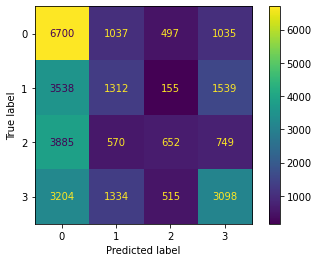

In [ ]:
TESTING_STRATIFIED(valence, arousal, stratified_all_labels, stratified_all_data)

In [ ]:
def RNN_LSTM_for_each_sample_in_each_song_prediction(valence, arousal, all_data):
  all_labels = get_all_labels_for_each_sample_in_song(valence, arousal)

  X, y = build_X_y(all_data, all_labels)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = build_model_for_each_sample_in_song_prediction((X_train.shape[1], X_train.shape[2]))

  optimise_fit_eval(model, X_train, X_test, y_train, y_test)

In [ ]:
def RNN_LSTM_for_each_song_prediction(valence, arousal, all_data):
  all_labels = get_all_labels_for_each_song(valence, arousal)

  X, y = build_X_y(all_data, all_labels)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = build_model_for_each_song_prediction((X_train.shape[1], X_train.shape[2]))

  optimise_fit_eval(model, X_train, X_test, y_train, y_test)

In [ ]:
RNN_LSTM_for_each_sample_in_each_song_prediction(valence, arousal, all_data)

In [ ]:
RNN_LSTM_for_each_song_prediction(valence, arousal, all_data)